# Simple OFDM example using the pytorch

OFDM_SDR_Functions_torch.py is is a collection of torch functions for building OFDM systems. It provides all required functions to generate data stream, OFDM signal and reconstruction back to a data stream. The functions utilise PyTorch where possible.

SDR_Pluto handles the transmission and reception of the signal over the air and utilising PlutoSDR software defined radio for it. Alternatively a simple radio channel model can be used instead of the SDR.

This jupyter notebook shows an example on how to use the libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from OFDM_SDR_Functions_torch import *
import SDR_Pluto
from config import *
import torch


# SDR Configuration
use_sdr = True # Set to `True` to use SDR for transmission and reception, or `False` to run the system in channel simulation mode.

SDR_TX_Frequency = int(434e6)  # SDR TX frequency in Hz
tx_gain = -0  # Transmission gain in dB for SDR
rx_gain = 10  # Reception gain in dB for SDR

# 3GPP Channel Simulation Parameters in case no sdr
ch_SINR = 25  # SINR for channel emulation

# OFDM Configuration is stored in config.py

save_plots=True

## OFDM System Parameters

### SDR Configuration (Optional)

- `use_sdr` (`bool`): Set to `True` to use SDR for transmission and reception, or `False` to run the system in simulation mode.
- `SDR_TX_Frequency` (`int`): SDR Transmission Frequency
- `tx_gain` (`int`): Transmission gain for the SDR
- `rx_gain` (`int`): Reception gain for the SDR
- `tx_frequency` (`float`): Transmission frequency

### 3GPP CDL-C Channel Simulation

In case `use_sdr` is set to False:
- `ch_SINR` (`int`): Signal-to-Interference-plus-Noise Ratio (SINR) for the CDL-C channel emulation

### OFDM System Configuration

- `Qm` (`int`): Modulation order
- `F` (`int`): Number of subcarriers
- `S` (`int`): Number of symbols,=
- `FFT_size` (`int`): FFT size
- `Fp` (`int`): Pilot subcarrier spacing
- `Sp` (`int`): Pilot symbol spacing
- `CP` (`int`): Cyclic Prefix length
- `SCS` (`int`): Subcarrier spacing
- `P` (`int`): Number of pilot subcarriers
- `sn` (`int`): Serial number starting value
- `Qm_sn` (`int`): Serial number modulation order
- `FFT_offset` (`int`): FFT offset, calculated as (FFT size - Number of subcarriers)/2.
- `SampleRate` (`float`): Sample rate, calculated as FFT size * Subcarrier spacing.
- `Ts` (`float`): Sample duration, calculated as 1/(Subcarrier spacing * FFT size).
- `TTI_duration` (`float`): TTI duration in ms, calculated using the provided formula.
- `Pilot_Power` (`float`): Power allocated for the pilot signals
- `PDSCH_power` (`float`): Power allocated for the PDSCH

### SINR Measurement

- `leading_zeros` (`int`): Number of symbols with zero value used for SINR measurement

## Create modulation mapping tables

Modulation mapping tables translate binary data sequences into complex symbols for transmission in digital communication systems. BPSK, QPSK, and 16-QAM, e.g. 64QAM, 256QAM 1024 QAM and so on are possible. The higher the modulation order, the higher the SINR requirement.

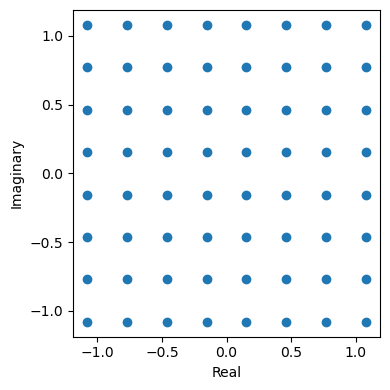

In [2]:
mapping_table_QPSK, de_mapping_table_QPSK = mapping_table(2) # mapping table QPSK (e.g. for pilot symbols)
mapping_table_Qm, de_mapping_table_Qm = mapping_table(Qm, plot=True) # mapping table for Qm

## Creating a TTI Mask with symbol allocations

A TTI mask represents the allocation of the complex symbols over a specific Transmission Time Interval (TTI). It is a matrix or a 2D array where the rows represent the time slots within a TTI, and the columns represent the available symbols in frequency domain. The values in the matrix indicate the use:

- `0`: The PRB is null power.
- `1`: The PRB is PDSCH.
- `2`: Pilot symbols

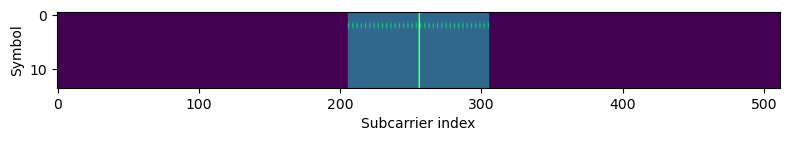

In [3]:
OFDM_mask = OFDM_block_mask(S=S,F=F, Fp=Fp, Sp=Sp, FFT_offset=FFT_offset, plotTTI=True)

## Creating and Inserting Pilot Symbols in OFDM

Pilot symbols are crucial in OFDM systems for reliable data transmission, aiding in channel estimation, synchronization, and error correction at the receiver. They are predefined, known symbols placed at specific intervals across the OFDM frame. Their known properties help the receiver in demodulating and decoding the received signal accurately.

In [4]:
pilot_symbols = pilot_set(OFDM_mask, Pilot_Power)

## Start the SDR

**Initialize the PlutoSDR Transceiver**: Create a PlutoSDR object and configure it with the appropriate transmission parameters including RF bandwidth, carrier frequency, and hardware gain.


In [5]:
# start the SDR 
if use_sdr:
     SDR_1 = SDR_Pluto.SDR(SDR_TX_IP="ip:192.168.1.10", SDR_TX_FREQ=SDR_TX_Frequency, SDR_TX_GAIN=tx_gain, SDR_RX_GAIN = rx_gain, SDR_TX_SAMPLERATE=SampleRate, SDR_TX_BANDWIDTH=F*SCS*2)
     SDR_1.SDR_TX_start()

## Data stream creation OFDM Modulation, FFT, and Cyclic Prefix Addition

Here a single data stream is created, modulated, FFT is applied, and cyclic prefix is added.


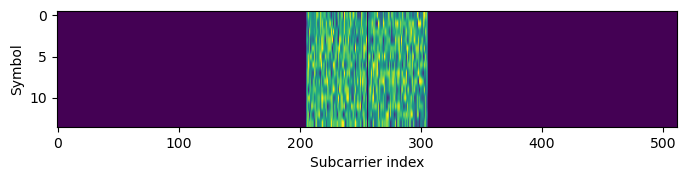

In [6]:
def create_OFDM_data():
    pdsch_bits, pdsch_symbols = create_payload(OFDM_mask, Qm, mapping_table_Qm, power=PDSCH_power) # create PDSCH data and modulate it
    Modulated_TTI = RE_mapping(OFDM_mask, pilot_symbols, pdsch_symbols, plotTTI=True) # map the PDSCH and pilot symbols to the TTI
    TD_TTI_IQ = IFFT(Modulated_TTI) # perform the FFT
    TX_Samples = CP_addition(TD_TTI_IQ, S, FFT_size, CP) # add the CP
    if use_sdr:
        zeros = torch.zeros(leading_zeros, dtype=TX_Samples.dtype) # create leading zeros for estimating noise floor power
        TX_Samples = torch.cat((zeros, TX_Samples), dim=0) # add leading zeros to TX samples
    return pdsch_bits, TX_Samples

pdsch_bits, TX_Samples = create_OFDM_data()

## Radio Channel - Transmitting and Receiving OFDM Symbols with PlutoSDR or a simulated channel

In [7]:
def radio_channel(use_sdr, tx_signal, tx_gain, rx_gain, ch_SINR):
    if use_sdr:
        SDR_1.SDR_gain_set(tx_gain, rx_gain) # set the gains
        SDR_1.SDR_TX_send(SAMPLES=tx_signal, max_scale=1, cyclic=True) # start transmitting the symbols in cyclic mode
        rx_signal = SDR_1.SDR_RX_receive(len(tx_signal)*4) # receive the signal
        SDR_1.SDR_TX_stop() # stop the transmission
    else:
        rx_signal = apply_multipath_channel(tx_signal, n_taps=n_taps, max_delay=max_delay, random_start=True, repeats=3, SINR=ch_SINR, leading_zeros=leading_zeros)
    return rx_signal

RX_Samples = radio_channel(use_sdr=use_sdr, tx_signal = TX_Samples, tx_gain = tx_gain, rx_gain = rx_gain, ch_SINR=ch_SINR) 

### Power Spectral Densities of transmitted and received signals

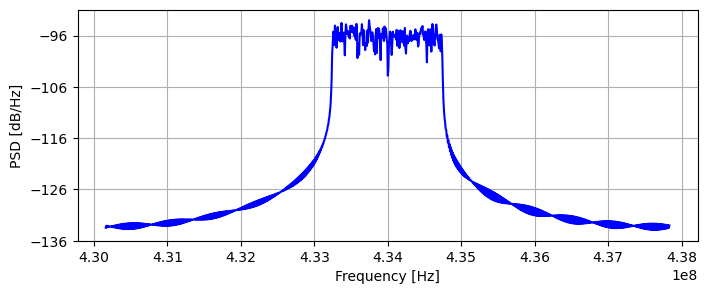

In [8]:
PSD_plot(TX_Samples, SampleRate, SDR_TX_Frequency, 'TX')

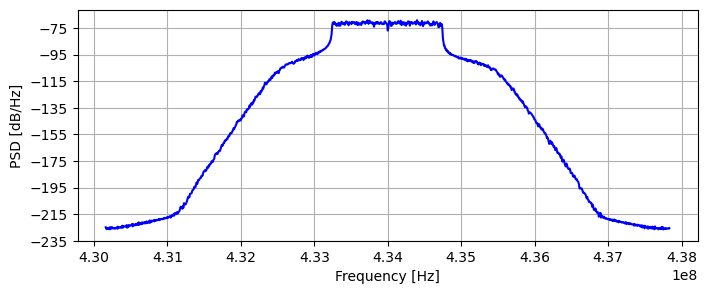

In [9]:
PSD_plot(RX_Samples, SampleRate, SDR_TX_Frequency, 'RX')

## Synchronization with Correlation for TTI Detection

Synchronization is achieved through correlation. The beginning of a Transmission Time Interval (TTI) us selected based on the first value exceeding an adjustable threshold. Cyclic prefix covers ISI for CP symbols from that point onwards.


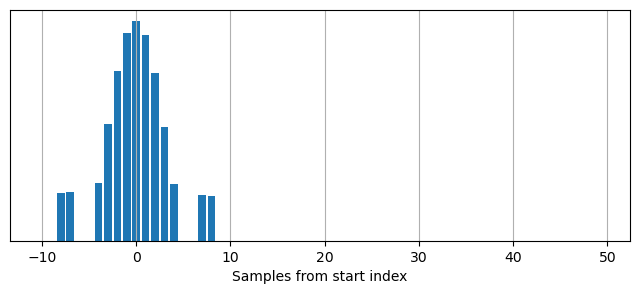

In [10]:
symbol_index, symbol_index_maxarg=sync_iq(TX_Samples, RX_Samples, leading_zeros=leading_zeros, threshold= 5, plot=True)
if use_sdr:
    symbol_index = symbol_index + leading_zeros

## SINR calculation

Null symbols were added into the beginning of each transmission to allow measuring the noise level at the receiver. The average power of transmitted symbols is divided by the average power of those null symbols. Note that this gives only a rough estimate, as in this simple implementation the null symbols outside the transmit bandwidth are included in transmitted power calculation.

$\text{SINR} = \frac{\text{Signal Power}}{\text{Interference Power} + \text{Noise Power}}$


In [11]:
SINR_m, noise_power, signal_power = SINR(RX_Samples, symbol_index, leading_zeros) # calculate the SINR

## Cyclic Prefix Removal

The cyclic prefix (CP) is added to each symbol to mitigate inter-symbol interference caused by multipath propagation. Once the signal is received, the CP must be removed to proceed with demodulation and data recovery.

/Users/riku/miniforge3/envs/pluto311/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/riku/miniforge3/envs/pluto311/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


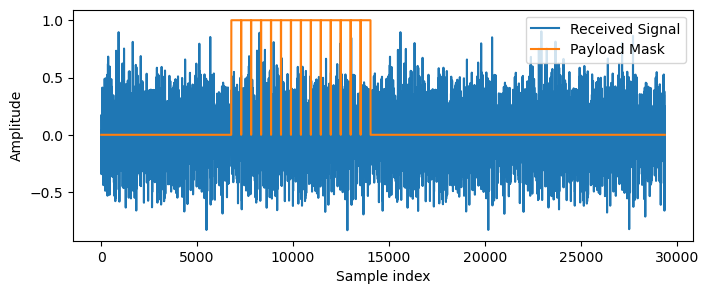

In [12]:
RX_NO_CP = CP_removal(RX_Samples, symbol_index, S, FFT_size, CP, plotsig=True) # remove the cyclic prefix
RX_NO_CP = RX_NO_CP / torch.max(torch.abs(RX_NO_CP)) # normalize the signal

## Convert the the time domain OFDM signal into frequency domain

Fast Fourier Transform (FFT) transforms the received time-domain signal back into the frequency domain, where data on individual subcarriers can be independently demodulated.


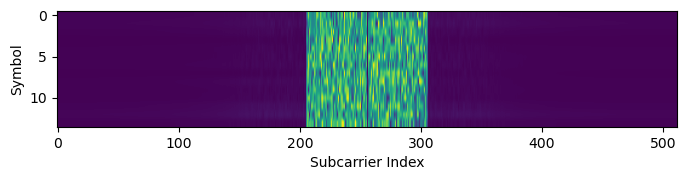

In [13]:
IQ_DFT = DFT(RX_NO_CP, plotDFT=True) # perform the DFT on the received signal and plot the result

## Channel Estimation

Channel estimation aims to characterize the channel's effect on the transmitted signal, which is essential for accurate data demodulation and improving system performance. 

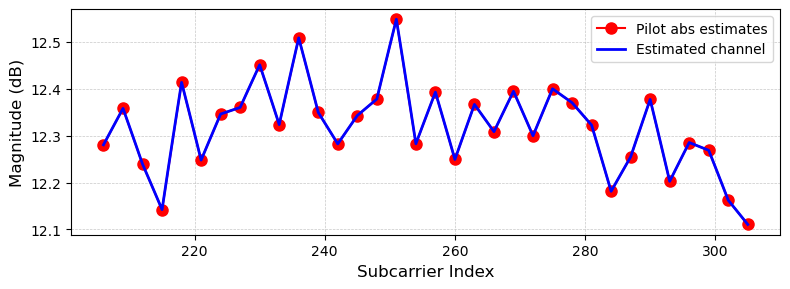

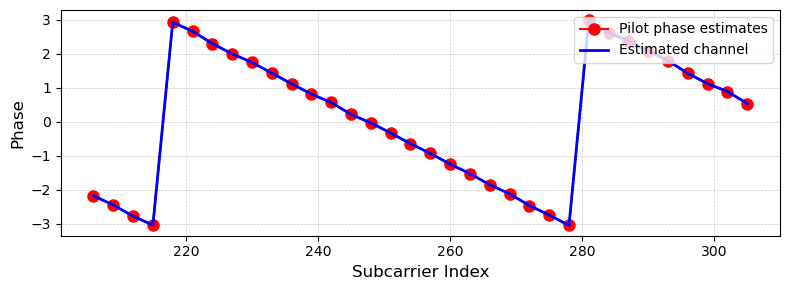

In [14]:
H_estim = channelEstimate_LS(OFDM_mask, pilot_symbols, F, FFT_offset, Sp, IQ_DFT, plotEst=True) # estimate the channel using least squares and plot

## Equalization in OFDM Systems

Equalization aims to mitigate the phase and amplitude variations introduced by the communication channel, ensuring accurate data recovery.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


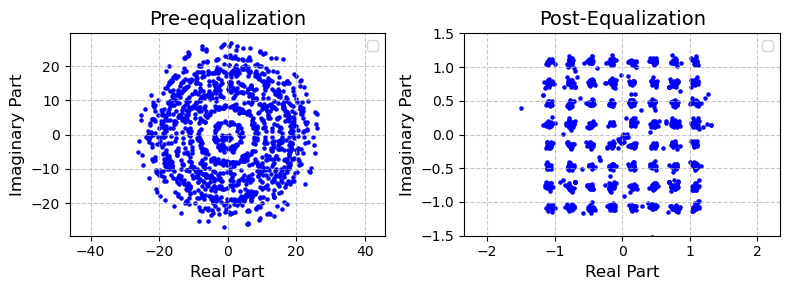

In [15]:
OFDM_demod_no_offsets = remove_fft_Offests(IQ_DFT, F, FFT_offset) # remove the FFT offsets and DC carrier from the received signal
equalized_H_estim = equalize_ZF(OFDM_demod_no_offsets, H_estim, F, S, plotQAM=True) # equalize the channel using ZF


## Payload Symbols extraction

The payload in an OFDM system refers to the actual data transmitted, excluding overheads like cyclic prefixes, pilot symbols, and any additional signaling or control information. 

In [16]:
QAM_est = get_payload_symbols(OFDM_mask, equalized_H_estim, FFT_offset, F) # get the payload symbols from the equalized signal

## Converting OFDM Symbols to Data

After receiving and processing the OFDM symbols, the final step is to convert them back into the original data stream. This process involves demodulation, demapping and combining the information to data stream.

In [17]:
PS_est, hardDecision = Demapping(QAM_est, de_mapping_table_Qm) # demap the symbols back to codewords
bits_est = PS(PS_est) # convert the codewords to the bitstream
print(bits_est)

tensor([1, 0, 0,  ..., 1, 0, 0], dtype=torch.int32)


## Calculating Bit Error Rate (BER) 

Understanding the performance of an OFDM system requires evaluating key metrics like Bit Error Rate (BER) and Signal-to-Interference-plus-Noise Ratio (SINR). The received data bits are compared to the original transmitted bits to identify errors.

$\text{BER} = \frac{\text{Number of Bit Errors}}{\text{Total Number of Transmitted Bits}}$


In [18]:
error_count = torch.sum(bits_est != pdsch_bits.flatten()).float()  # Count of unequal bits
error_rate = error_count / bits_est.numel()  # Error rate calculation
BER = torch.round(error_rate * 1000) / 1000  # Round to 3 decimal places
print(f"BER: {BER}, SINR: {SINR_m}dB") # print the BER and SINR


BER: 0.024000000208616257, SINR: 31.7dB


## Visualize bit errors

Bit error visualisation to help finding any systematic problems - well - in the system

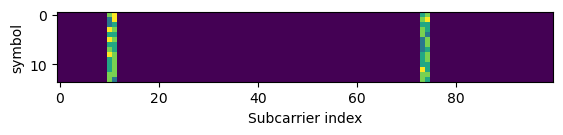

In [19]:
# Create a zero tensor for the overall F subcarriers * S symbols
OFDM_block = np.zeros(OFDM_mask.shape)

# Allocate the payload and pilot
errors = (bits_est != pdsch_bits.flatten()).reshape(-1, Qm).sum(axis=1)

OFDM_block[OFDM_mask==1] = errors


plt.imshow(OFDM_block[:,FFT_offset:FFT_offset+F])
plt.xlabel('Subcarrier index')
plt.ylabel('symbol')
plt.savefig('pics/bit_errors.png', bbox_inches='tight')